In [1]:
import xarray as xr

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# to work with rasters
# https://rasterio.readthedocs.io/en/latest/quickstart.html#opening-a-dataset-in-reading-mode
import rasterio as rio
from rasterio.plot import show
from rasterio.features import shapes

import cv2
# pip install opencv-python-headless
# https://pypi.org/project/opencv-python/

from shapely.geometry import Polygon
from shapely.affinity  import affine_transform
import geopandas as gpd

In [44]:
# EXTRACT POLYGONS FROM REGIONS
# we are reusing the functions previoysly coded in temp_increase_regions.ipynb notebook @ Aurora server

# ------------------------------------------------------------------

# shape is a single JSON-ish polygon coming from the rasterio.features.shapes function
# rasterio.features.shapes returns a list of pairs (shape, value), example of a pair:
#   ({'type': 'Polygon', 'coordinates': [[(6,0),(6,2),(8,0),(6,0)]]}, 1.0)
#   shape is the first entry (the dictionary)
def create_polygon(shape):
    
    poly_list = shape.get('coordinates')

    if len(poly_list) == 1:    # polygon without holes
        return Polygon(poly_list[0])

    holes = []
    for i in range(1,len(poly_list)):
        holes.append(poly_list[i])
    return Polygon(shell=poly_list[0], holes=holes)

# ------------------------------------------------------------------

# shapes_list is the output from rasterio.features.shapes (type generator, iterable once)
# crs that will be assigned to the GeoDataFrame
def shapes_2_GeoDataFrame(shapes_list, crs = False):

    df = gpd.GeoDataFrame() 
    i = 0
    for shape, value in shapes_list:
        df.loc[i,'geometry'] = create_polygon(shape)
        i = i+1

    if(crs != False):
        df.crs = crs
    
    return df
    

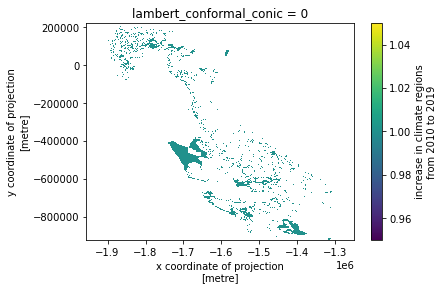

In [6]:
path = "/home/jovyan/climate_layer/clim_increase_10_19.nc"
clim_rgns = xr.open_dataarray(path)
clim_rgns.plot()

## EXTRACT CRS AND AFFINE TRANSFORMATION FROM DATARRAY
When we take a look at the `clim_rgns` xarray.DataArray we can see one of its coordinates is *lambert_conformal_conic*. 
If we click on it we can see this is a dictionary with a ton of information about the CRS of this data array. 
Following the example in notebook* we can use this information to create an object of type `cartopy.crs.LambertConformal`. 

In [34]:
clim_rgns

<xarray.DataArray (y: 1149, x: 706)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y                        (y) float32 2.24e+05 2.23e+05 ... -9.24e+05
  * x                        (x) float32 -1.955e+06 -1.954e+06 ... -1.25e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
    lambert_conformal_conic  int64 0
Attributes:
    grid_mapping:    lambert_conformal_conic
    long_name:       increase in climate regions from 2010 to 2019
    years_compared:  [2010 2019]

In [28]:
# extract crs from coords at xarray.DataArray
import cartopy.crs as ccrs

lcc = clim_rgns.coords['lambert_conformal_conic'].attrs

prj_kwargs = dict(
    central_latitude=lcc["latitude_of_projection_origin"],
    central_longitude=lcc["longitude_of_central_meridian"],
    standard_parallels=(lcc["standard_parallel"]),
)
crs = ccrs.LambertConformal(**prj_kwargs)

crs

<Derived Projected CRS: +proj=lcc +ellps=WGS84 +lon_0=-100.0 +lat_0=42.5 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We will also need to extract its affine transformation or GeoTransform (that last key in the coords dict).
Some useful references about what this is are:

https://www.perrygeo.com/python-affine-transforms.html

https://gis.stackexchange.com/questions/379005/using-raster-transform-function-of-rasterio-in-python

https://www.gis.usu.edu/~chrisg/python/2009/lectures/ospy_slides4.pdf

https://rasterio.readthedocs.io/en/latest/topics/georeferencing.html?highlight=affine#affine

| x' |   | a  b  c | | x |
| y' | = | d  e  f | | y |
| 1  |   | 0  0  1 | | 1 |

We obtain a string (annoying) of six numbers which mean the following:
- c = GeoTransform[0] = top left x
- a = GeoTransform[1] = w-e pixel resolution 
- b = GeoTransform[2]  = row rotation, 0 if image is "north up" 
- f = GeoTransform[3] = top left y 
- d = GeoTransform[4] = column rotation, 0 if image is "north up" 
- e = GeoTransform[5] = n-s pixel resolution (typically negative)



In [30]:
geotransf = clim_rgns.coords['lambert_conformal_conic'].attrs['GeoTransform']
geotransf

'-1955750.0 1000.0 0.0 224500.0 0.0 -1000.0'

In [39]:
import affine
aff= affine.Affine(1000.0, 0.0,-1955750.0, 0.0, -1000.0, 224500.0)
aff

Affine(1000.0, 0.0, -1955750.0,
       0.0, -1000.0, 224500.0)

## Thickening regions

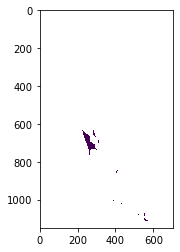

<AxesSubplot:>

In [40]:
np_rgns = clim_rgns.to_numpy()
show(np_rgns)

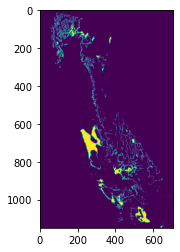

<AxesSubplot:>

In [41]:
thick_regions = cv2.dilate(np_rgns, np.ones((3,3), np.uint8), iterations=1)
thick_regions = thick_regions.astype('uint8')  
show(thick_regions)

In [42]:
np.unique(thick_regions)

array([0, 1], dtype=uint8)

In [48]:
# shapes_list is type generator: iterable once
thick_shps = shapes(source = thick_regions, 
                     mask= thick_regions,   # include this so regions with value 0 are not inclduded
                     connectivity = 8,
                     transform = aff)

aff_data = shapes_2_GeoDataFrame(thick_shps , crs)
aff_data

,geometry
0,"POLYGON ((-1861750.000 210500.000, -1861750.00..."
1,"POLYGON ((-1859750.000 210500.000, -1859750.00..."
2,"POLYGON ((-1869750.000 209500.000, -1869750.00..."
3,"POLYGON ((-1845750.000 209500.000, -1845750.00..."
4,"POLYGON ((-1843750.000 207500.000, -1843750.00..."
...,...
2679,"POLYGON ((-1458750.000 -901500.000, -1458750.0..."
2680,"POLYGON ((-1456750.000 -903500.000, -1456750.0..."
2681,"POLYGON ((-1453750.000 -907500.000, -1453750.0..."
2682,"POLYGON ((-1309750.000 -910500.000, -1305750.0..."


In [51]:
outfp = "/home/jovyan/climate_layer/clim_increase_10_19/clim_increase_10_19.shp"
aff_data.to_file(outfp)

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
